# EDA

In [2]:
import sys

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from nltk.corpus import stopwords
from transformers import pipeline
from wordcloud import WordCloud

In [3]:
if "google.colab" in sys.modules:
    !wget https://storage.yandexcloud.net/travel-rag/dataset/geo-reviews-dataset-2023.csv

In [4]:
df = pd.read_csv("../data/raw/geo-reviews-dataset-2023.csv")

## Basic info

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   address  500000 non-null  object 
 1   name_ru  499030 non-null  object 
 2   rating   500000 non-null  float64
 3   rubrics  500000 non-null  object 
 4   text     500000 non-null  object 
dtypes: float64(1), object(4)
memory usage: 19.1+ MB


In [8]:
# В датасете присутствуют null-названия мест
df.isnull().sum()

address      0
name_ru    970
rating       0
rubrics      0
text         0
dtype: int64

In [9]:
df[df["name_ru"].isnull()]

,address,name_ru,rating,rubrics,text
322,"Москва, 8-я улица Соколиной Горы, 15А, стр. 23",NaN,5.0,Офис организации,"Ребята профи!\n\nОтлично подобрали модель, съе..."
5716,"Челябинская область, Златоуст, Таганайская ули...",NaN,5.0,Гостиница,"Гостиница действительно хорошая, удобно распол..."
5717,"Челябинская область, Златоуст, Таганайская ули...",NaN,5.0,Гостиница,Был здесь на кулинарном мастер-классе. Место а...
5718,"Челябинская область, Златоуст, Таганайская ули...",NaN,5.0,Гостиница,"Тихое место, в выходные возможно и шумно так к..."
5719,"Челябинская область, Златоуст, Таганайская ули...",NaN,5.0,Гостиница,"Воспитанные и отзывчивые официанты , вкусная к..."
...,...,...,...,...,...
498536,"Республика Башкортостан, Уфа, улица Менделеева...",NaN,5.0,"Скалодром;Спортивный клуб, секция",Были с детьми на 8 марта. Приехали специально ...
498688,"Москва, Юго-Восточный административный округ, ...",NaN,5.0,Изготовление памятников и надгробий;Изделия из...,"Отличное качество материала, прекрасное исполн..."
498913,"Самарская область, Волжский район, жилой район...",NaN,1.0,Магазин цветов;Копировальный центр;Товары для ...,"Цен на цветы которые находятся на витрине нет,..."
499006,"Волгоград, улица Гроссмана, 6",NaN,5.0,Салон красоты,Квалифицированные мастера. Работу выполняют с ...


In [7]:
df.describe(include="all")

,address,name_ru,rating,rubrics,text
count,500000,499030,500000.00000,500000,500000
unique,191925,148456,NaN,31793,499885
top,"Москва, Ходынский бульвар, 4",Пятёрочка,NaN,Гостиница,Хороший магазин\n
freq,340,6030,NaN,42242,10
mean,NaN,NaN,4.48160,NaN,NaN
std,NaN,NaN,1.14625,NaN,NaN
min,NaN,NaN,0.00000,NaN,NaN
25%,NaN,NaN,5.00000,NaN,NaN
50%,NaN,NaN,5.00000,NaN,NaN
75%,NaN,NaN,5.00000,NaN,NaN


## Распределение рейтинга

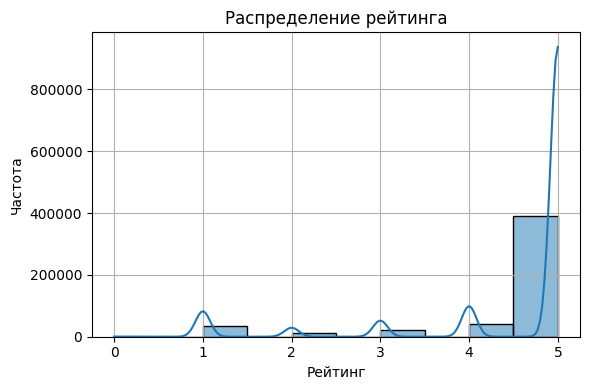

In [8]:
plt.figure(figsize=(6, 4))
sns.histplot(df["rating"].dropna(), bins=10, kde=True)
plt.title("Распределение рейтинга")
plt.xlabel("Рейтинг")
plt.ylabel("Частота")
plt.grid(True)
plt.tight_layout()
plt.show()

## Распределение рубрик

In [6]:
df["rubrics_list"] = df["rubrics"].str.split(";")
df["rubrics_list"].head()

0                                     [Жилой комплекс]
1    [Магазин продуктов, Продукты глубокой заморозк...
2                                        [Фитнес-клуб]
3      [Пункт проката, Прокат велосипедов, Сапсёрфинг]
4    [Салон красоты, Визажисты, стилисты, Салон бро...
Name: rubrics_list, dtype: object

/var/folders/hy/9y5wfvks4m55vpklg49y7g0r0000gn/T/ipykernel_51455/3738959253.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


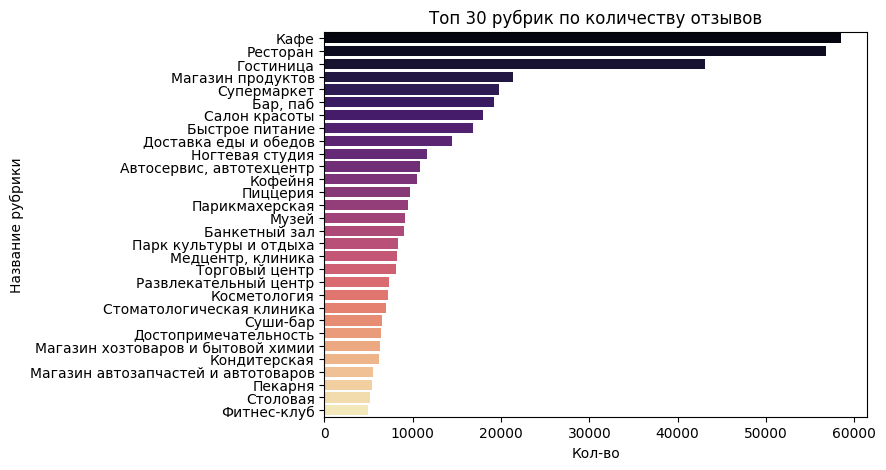

In [7]:
exploded = df.explode("rubrics_list")
exploded["rubrics_list"] = exploded["rubrics_list"].str.strip()

top_n = 30
top_rubrics = exploded["rubrics_list"].value_counts().nlargest(top_n).index

plt.figure(figsize=(7, 5))
sns.countplot(
    y="rubrics_list", data=exploded[exploded["rubrics_list"].isin(top_rubrics)], order=top_rubrics, palette="magma"
)
plt.title(f"Топ {top_n} рубрик по количеству отзывов")
plt.xlabel("Кол-во")
plt.ylabel("Название рубрики")
plt.show()

In [8]:
df.drop(columns=["rubrics_list"], inplace=True)

## Анализ отзывов

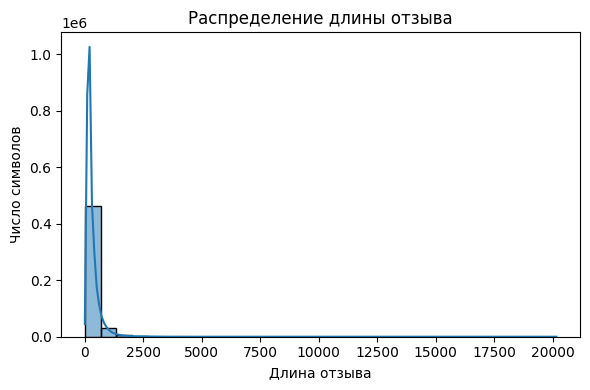

In [12]:
df["text_length"] = df["text"].astype(str).apply(len)

plt.figure(figsize=(6, 4))
sns.histplot(df["text_length"], bins=30, kde=True)
plt.title("Распределение длины отзыва")
plt.xlabel("Длина отзыва")
plt.ylabel("Число символов")
plt.tight_layout()
plt.show()

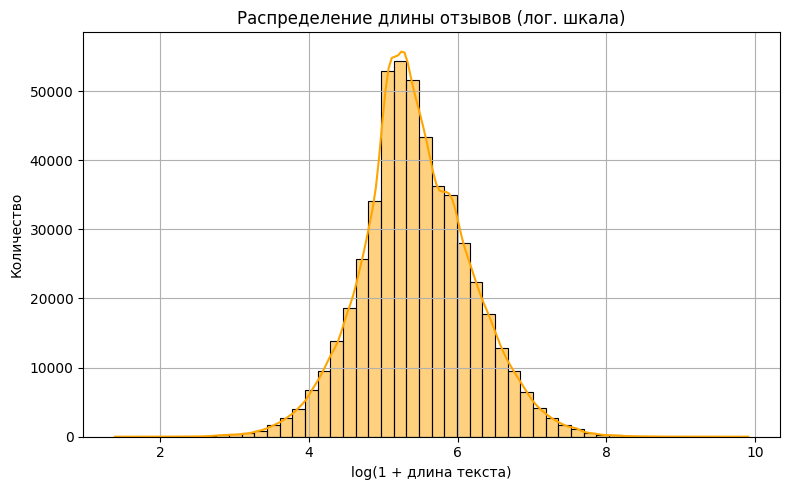

In [13]:
# Более подробно

plt.figure(figsize=(8, 5))
sns.histplot(np.log1p(df["text_length"]), bins=50, kde=True, color="orange")
plt.title("Распределение длины отзывов (лог. шкала)")
plt.xlabel("log(1 + длина текста)")
plt.ylabel("Количество")
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
print("Средняя длина отзыва в символах:", int(df["text_length"].mean()))

Средняя длина отзыва в символах: 304


### WordCloud

Не будем учитывать стоп-слова

In [15]:
nltk.download("stopwords")
nltk.download("punkt_tab")

[nltk_data] Downloading package stopwords to /home/seara/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/seara/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

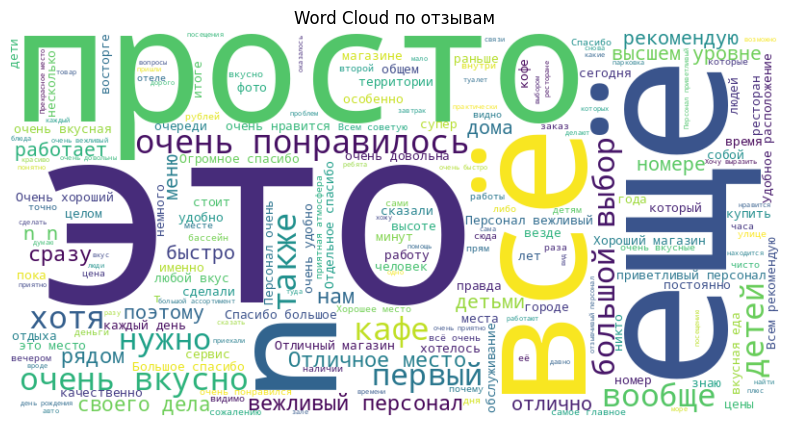

In [16]:
stop_words = set(stopwords.words("russian"))

wordcloud = WordCloud(width=800, height=400, background_color="white", stopwords=stop_words).generate(
    " ".join(df["text"].astype(str).dropna())
)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud по отзывам")
plt.show()

### Sentiment analysis

Возьмем для примера 10К случайных отзывов из датасета и посмотрим на них подробнее

In [17]:
RANDOM_STATE = 42

# sample_df = df.sample(100_000, random_state=42)
sample_df = df

In [18]:
model = pipeline(model="seara/rubert-tiny2-russian-sentiment", device="cuda")
texts = sample_df["text"].tolist()

results = model(texts, batch_size=32, truncation=True)

sample_df[["sentiment", "sentiment_confidence"]] = pd.DataFrame(
    [(res["label"], res["score"]) for res in results], index=sample_df.index
)

Device set to use cuda


In [19]:
sample_df["sentiment"].value_counts()

sentiment
positive    371984
neutral      93181
negative     34835
Name: count, dtype: int64

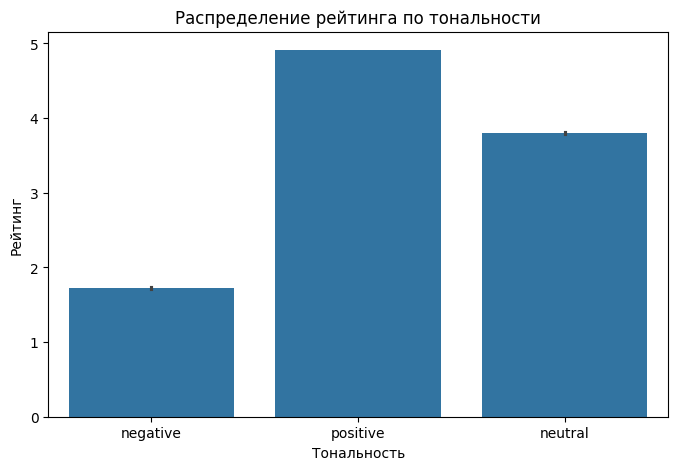

In [20]:
plt.figure(figsize=(8, 5))
sns.barplot(data=sample_df, x="sentiment", y="rating")
plt.title("Распределение рейтинга по тональности")
plt.xlabel("Тональность")
plt.ylabel("Рейтинг")
plt.show()

## Статистика по городам

In [10]:
df["region"] = df["address"].astype(str).str.split(",").str[0].str.strip()

grouped = df.groupby("region").size().reset_index(name="count").sort_values("count", ascending=False)
grouped

,region,count
160,Москва,104774
268,Санкт-Петербург,52568
162,Московская область,49953
127,Краснодарский край,29646
247,Республика Татарстан,11662
...,...,...
231,Р-298,1
352,Южное кладбище,1
353,Якутия,1
354,Якутск,1


In [11]:
threshold = 9  # сколько записей нужно по региону, чтобы оставить его при фильтрации


counts = df["region"].value_counts()
valid_groups = counts[counts >= threshold].index

df_filtered = df[df["region"].isin(valid_groups)]
print(f"Удалено {df.shape[0] - df_filtered.shape[0]} записей при фильтрации")

grouped = df_filtered.groupby("region").size().reset_index(name="count").sort_values("count", ascending=False)
grouped

Удалено 604 записей при фильтрации


,region,count
76,Москва,104774
142,Санкт-Петербург,52568
78,Московская область,49953
60,Краснодарский край,29646
127,Республика Татарстан,11662
...,...,...
135,Рязанская обл.,9
209,городской округ Томск,9
179,Ханты-Мансийский АО,9
150,Сибирский федеральный округ,9


In [12]:
# TOP 20
grouped.head(20)

,region,count
76,Москва,104774
142,Санкт-Петербург,52568
78,Московская область,49953
60,Краснодарский край,29646
127,Республика Татарстан,11662
148,Свердловская область,11617
59,Краснодар,9073
85,Нижний Новгород,8545
70,Ленинградская область,8409
122,Республика Крым,8128


Text(0, 0.5, 'Название региона')

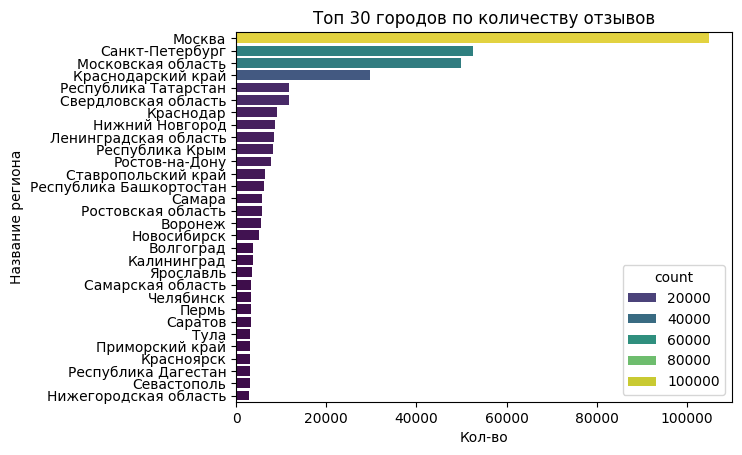

In [47]:
# TOP 20 городов
sns.barplot(data=grouped.head(30), x="count", y="region", hue="count", palette="viridis")
plt.title("Топ 30 городов по количеству отзывов")
plt.xlabel("Кол-во")
plt.ylabel("Название региона")

/var/folders/hy/9y5wfvks4m55vpklg49y7g0r0000gn/T/ipykernel_51455/2352470922.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
/var/folders/hy/9y5wfvks4m55vpklg49y7g0r0000gn/T/ipykernel_51455/2352470922.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=grouped_, x="count", y="region", palette="magma", ax=axes[1])


Text(0, 0.5, 'Название региона')

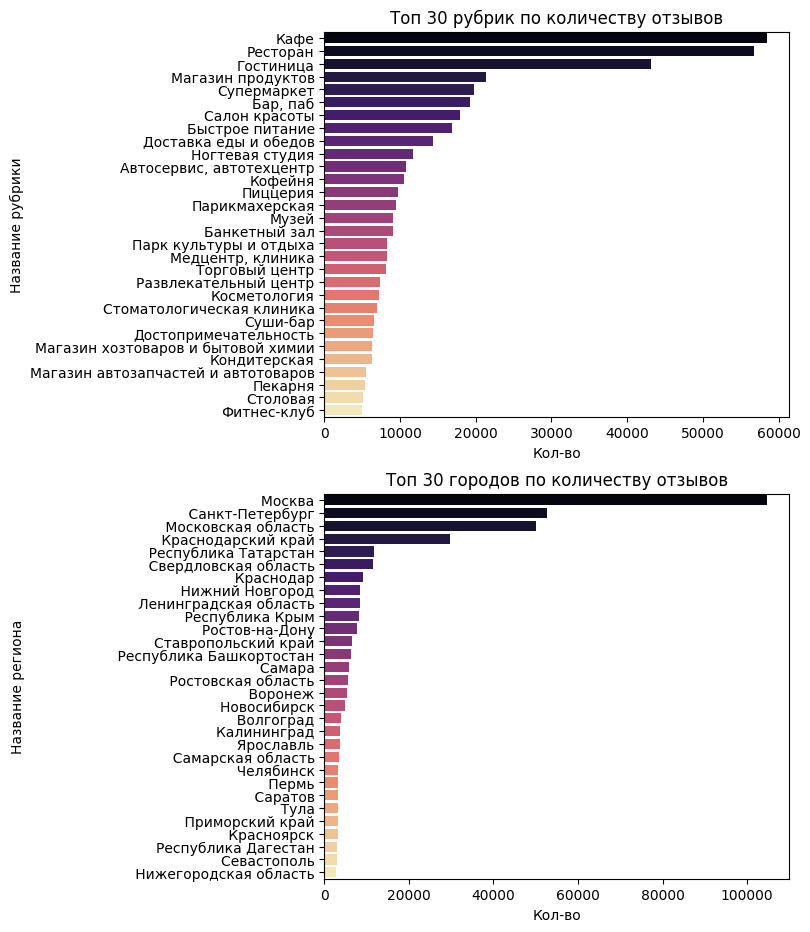

In [15]:
fig, axes = plt.subplots(2, 1, figsize=(6, 11), sharex=False)  # shared Y

sns.countplot(
    y="rubrics_list",
    data=exploded[exploded["rubrics_list"].isin(top_rubrics)],
    order=top_rubrics,
    palette="magma",
    ax=axes[0],
)

max_len = exploded[exploded["rubrics_list"].isin(top_rubrics)]["rubrics_list"].str.len().max()
grouped_ = grouped.head(30).copy()
grouped_["region"] = grouped_["region"].apply(lambda x: x.rjust(max_len + 8))  # + 8
sns.barplot(data=grouped_, x="count", y="region", palette="magma", ax=axes[1])


axes[0].set_title(f"Топ {top_n} рубрик по количеству отзывов")
axes[0].set_xlabel("Кол-во")
axes[0].set_ylabel("Название рубрики")
axes[1].set_title("Топ 30 городов по количеству отзывов")
axes[1].set_xlabel("Кол-во")
axes[1].set_ylabel("Название региона")